### Import Required Libraries

In [1]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features (Fold-Change Only)

In [2]:
import pandas as pd
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load Fold-Change selected features
def load_fold_change_features(file_path, num_features=10):
    if os.path.exists(file_path):
        fc_data = pd.read_csv(file_path)

        # Ensure the required column exists
        if "log2_fold_change" in fc_data.columns and "Unnamed: 0" in fc_data.columns:
            selected_features = fc_data.nlargest(num_features, "log2_fold_change")["Unnamed: 0"].tolist()
            logging.info(f"Loaded top {num_features} Fold-Change features.")
            return selected_features
        else:
            raise ValueError(f"Expected columns not found in {file_path}. Ensure 'log2_fold_change' and 'Unnamed: 0' exist.")
    else:
        raise FileNotFoundError(f"Fold-Change feature selection file not found: {file_path}")

# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Select top Fold-Change features
num_features_to_select = 500  # Change as needed
top_features = load_fold_change_features(file_paths["fold_change"], num_features=num_features_to_select)

# Ensure only valid miRNA features are selected (remove metadata like 'stage' and 'subtype' if present)
filtered_features = [feature for feature in top_features if feature.startswith("hsa-mir-")]

# Ensure the selected miRNAs are in the processed dataset
available_features = [feature for feature in filtered_features if feature in processed_data.columns]

# Final Check: Ensure count matches actual miRNAs displayed
logging.info(f"Total valid miRNAs used in classification: {len(available_features)}")

# Display selected miRNAs
print("\nSelected miRNAs for Classification:")
for i, miRNA in enumerate(available_features, 1):
    print(f"{i}. {miRNA}")

# Save cleaned miRNAs to a new CSV file
cleaned_miRNAs_df = pd.DataFrame(available_features, columns=["Selected_miRNAs"])
cleaned_miRNAs_df.to_csv("../results/cleaned_fold_change_miRNAs.csv", index=False)

print("\nProcessing complete. Selected features saved.")

2025-02-26 17:26:04,914 - INFO - Loaded top 500 Fold-Change features.
2025-02-26 17:26:04,915 - INFO - Total valid miRNAs used in classification: 498



Selected miRNAs for Classification:
1. hsa-mir-518f
2. hsa-mir-520e
3. hsa-mir-520d
4. hsa-mir-1283-2
5. hsa-mir-520h
6. hsa-mir-523
7. hsa-mir-519d
8. hsa-mir-515-2
9. hsa-mir-524
10. hsa-mir-521-2
11. hsa-mir-3927
12. hsa-mir-448
13. hsa-mir-4487
14. hsa-mir-526a-2
15. hsa-mir-4678
16. hsa-mir-519e
17. hsa-mir-3689b
18. hsa-mir-518d
19. hsa-mir-5589
20. hsa-mir-3125
21. hsa-mir-1264
22. hsa-mir-3688-1
23. hsa-mir-4651
24. hsa-mir-3688-2
25. hsa-mir-1303
26. hsa-mir-4436b-2
27. hsa-mir-4739
28. hsa-mir-520a
29. hsa-mir-4735
30. hsa-mir-3929
31. hsa-mir-4505
32. hsa-mir-4512
33. hsa-mir-6811
34. hsa-mir-4466
35. hsa-mir-4653
36. hsa-mir-3938
37. hsa-mir-1285-1
38. hsa-mir-4451
39. hsa-mir-4701
40. hsa-mir-510
41. hsa-mir-3132
42. hsa-mir-2117
43. hsa-mir-890
44. hsa-mir-3133
45. hsa-mir-4679-1
46. hsa-mir-3659
47. hsa-mir-6785
48. hsa-mir-499b
49. hsa-mir-4776-2
50. hsa-mir-4671
51. hsa-mir-7151
52. hsa-mir-6791
53. hsa-mir-4427
54. hsa-mir-4776-1
55. hsa-mir-4498
56. hsa-mir-6862-1
5

### Process Features & Labels for Multi-Output Classification (Fold-Change Only)

In [3]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Remove subtype 4 before splitting (since it only has 1 sample)
filtered_data = filtered_data[filtered_data["subtype"] != 4]

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again
expression_values = filtered_data[top_features]

# Train-Test Split for Diagnosis Model (Healthy vs. Cancer)
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, filtered_data["diagnosis"], test_size=0.2, random_state=42, stratify=filtered_data["diagnosis"]
)

# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data[cancer_only][["stage", "subtype"]]

# Verify updated class distribution
print("\nUpdated class distribution for 'subtype':")
print(y_cancer["subtype"].value_counts())

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\nSome classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

# Define y for consistency
y = y_cancer  # Ensures `y_test` and `y_train` exist later

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nUpdated Training set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nUpdated Training set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nUpdated Testing set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nUpdated Testing set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())


Updated class distribution for 'subtype':
subtype
1    560
2    512
Name: count, dtype: int64

Class distribution in cancer dataset before splitting:
stage  subtype
1      1          312
       2          254
2      2          174
       1          134
3      1           90
       2           84
4      1           24
Name: count, dtype: int64

Updated Train-Test Split Information:
Diagnosis Model - Training set: (866, 500), Testing set: (217, 500)
Stage & Subtype Model - Training set: (857, 500), Testing set: (215, 500)

Updated Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Updated Training set class distribution (Stage & Subtype):
stage  subtype
1      1          250
       2          203
2      2          139
       1          107
3      1           72
       2           67
4      1           19
Name: count, dtype: int64

Updated Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Up

### Train-Test Split & Feature Scaling (Fold-Change Only)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Validate Selected Features
print("\nInitial data check:")
print("Top features:", top_features)
print("Number of top features:", len(top_features))

top_features = [feature for feature in top_features if feature in filtered_data.columns]
if not top_features:
    raise ValueError("No matching features found in processed data for the selected feature set.")

# Filter and Prepare Data
expression_values = filtered_data[top_features]

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': top_features
}


Initial data check:
Top features: ['hsa-mir-518f', 'stage', 'subtype', 'hsa-mir-520e', 'hsa-mir-520d', 'hsa-mir-1283-2', 'hsa-mir-520h', 'hsa-mir-523', 'hsa-mir-519d', 'hsa-mir-515-2', 'hsa-mir-524', 'hsa-mir-521-2', 'hsa-mir-3927', 'hsa-mir-448', 'hsa-mir-4487', 'hsa-mir-526a-2', 'hsa-mir-4678', 'hsa-mir-519e', 'hsa-mir-3689b', 'hsa-mir-518d', 'hsa-mir-5589', 'hsa-mir-3125', 'hsa-mir-1264', 'hsa-mir-3688-1', 'hsa-mir-4651', 'hsa-mir-3688-2', 'hsa-mir-1303', 'hsa-mir-4436b-2', 'hsa-mir-4739', 'hsa-mir-520a', 'hsa-mir-4735', 'hsa-mir-3929', 'hsa-mir-4505', 'hsa-mir-4512', 'hsa-mir-6811', 'hsa-mir-4466', 'hsa-mir-4653', 'hsa-mir-3938', 'hsa-mir-1285-1', 'hsa-mir-4451', 'hsa-mir-4701', 'hsa-mir-510', 'hsa-mir-3132', 'hsa-mir-2117', 'hsa-mir-890', 'hsa-mir-3133', 'hsa-mir-4679-1', 'hsa-mir-3659', 'hsa-mir-6785', 'hsa-mir-499b', 'hsa-mir-4776-2', 'hsa-mir-4671', 'hsa-mir-7151', 'hsa-mir-6791', 'hsa-mir-4427', 'hsa-mir-4776-1', 'hsa-mir-4498', 'hsa-mir-6862-1', 'hsa-mir-4425', 'hsa-mir-4520

### Train Multi-Output SVM Model (Fold-Change Only)

In [23]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 10],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Initialize metrics dictionary
metrics = {}

# Train Diagnosis SVM
print("\nTraining Diagnosis SVM...")
svm_diagnosis = SVC(class_weight="balanced", random_state=42)
grid_diagnosis = GridSearchCV(svm_diagnosis, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_diagnosis.fit(X_train_diagnosis, y_train_diagnosis)

best_svm_diagnosis = grid_diagnosis.best_estimator_
y_pred_diagnosis = best_svm_diagnosis.predict(X_test_diagnosis)

# Calculate Sensitivity & Specificity
cm_diagnosis = confusion_matrix(y_test_diagnosis, y_pred_diagnosis)
sensitivity_diagnosis = cm_diagnosis[1,1] / (cm_diagnosis[1,1] + cm_diagnosis[1,0]) if (cm_diagnosis[1,1] + cm_diagnosis[1,0]) > 0 else 0
specificity_diagnosis = cm_diagnosis[0,0] / (cm_diagnosis[0,0] + cm_diagnosis[0,1]) if (cm_diagnosis[0,0] + cm_diagnosis[0,1]) > 0 else 1

# Store metrics
metrics["diagnosis"] = {
    "accuracy": accuracy_score(y_test_diagnosis, y_pred_diagnosis),
    "sensitivity": sensitivity_diagnosis,
    "specificity": specificity_diagnosis,
    "classification_report": classification_report(y_test_diagnosis, y_pred_diagnosis, zero_division=0)
}

print("\nBest SVM Hyperparameters (Diagnosis):", grid_diagnosis.best_params_)
print("\nClassification Report for Diagnosis:\n", metrics["diagnosis"]["classification_report"])

# Train Stage SVM
print("\nTraining Stage SVM...")
svm_stage = SVC(class_weight="balanced", random_state=42)
grid_stage = GridSearchCV(svm_stage, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_stage.fit(X_train_cancer, y_train_cancer["stage"])

best_svm_stage = grid_stage.best_estimator_
y_pred_stage = best_svm_stage.predict(X_test_cancer)

# Calculate Sensitivity & Specificity
cm_stage = confusion_matrix(y_test_cancer["stage"], y_pred_stage)
sensitivity_stage = np.nanmean(np.diag(cm_stage) / np.sum(cm_stage, axis=1))
specificity_stage = np.nanmean(np.diag(cm_stage) / np.sum(cm_stage, axis=0))

# Store metrics
metrics["stage"] = {
    "accuracy": accuracy_score(y_test_cancer["stage"], y_pred_stage),
    "sensitivity": sensitivity_stage,
    "specificity": specificity_stage,
    "classification_report": classification_report(y_test_cancer["stage"], y_pred_stage, zero_division=0)
}

print("\nBest SVM Hyperparameters (Stage):", grid_stage.best_params_)
print("\nClassification Report for Stage:\n", metrics["stage"]["classification_report"])

# Train Subtype SVM
print("\nTraining Subtype SVM...")
svm_subtype = SVC(class_weight="balanced", random_state=42)
grid_subtype = GridSearchCV(svm_subtype, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_subtype.fit(X_train_cancer, y_train_cancer["subtype"])

best_svm_subtype = grid_subtype.best_estimator_
y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

# Calculate Sensitivity & Specificity
cm_subtype = confusion_matrix(y_test_cancer["subtype"], y_pred_subtype)
sensitivity_subtype = np.nanmean(np.diag(cm_subtype) / np.sum(cm_subtype, axis=1))
specificity_subtype = np.nanmean(np.diag(cm_subtype) / np.sum(cm_subtype, axis=0))

# Store metrics
metrics["subtype"] = {
    "accuracy": accuracy_score(y_test_cancer["subtype"], y_pred_subtype),
    "sensitivity": sensitivity_subtype,
    "specificity": specificity_subtype,
    "classification_report": classification_report(y_test_cancer["subtype"], y_pred_subtype, zero_division=0)
}

print("\nBest SVM Hyperparameters (Subtype):", grid_subtype.best_params_)
print("\nClassification Report for Subtype:\n", metrics["subtype"]["classification_report"])


Training Diagnosis SVM...

Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Training Stage SVM...

Best SVM Hyperparameters (Stage): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           1       0.78      0.98      0.87       113
           2       0.81      0.63      0.71        62
           3       0.79      0.54      0.64        35
           4       0.00      0.00      0.00         5

    accuracy                           0.79       215
   macro avg       0.60      0.54      0.56       215
weighted a

### Evaluate SVM Model (Fold-Change)


⚠️ X_train was not a DataFrame, converting it now...

Top 10 Features Based on Maximum Variance:
['Feature_489', 'Feature_406', 'Feature_308', 'Feature_476', 'Feature_284', 'Feature_85', 'Feature_205', 'Feature_342', 'Feature_337', 'Feature_259']

Top features saved to ../results/svm_fold_change/svm_fold_change_top_features.txt

-------------------- SVM (Fold-Change) Results --------------------

-------------------- SVM_Diagnosis Results --------------------

Accuracy: 0.9907
Sensitivity (Recall): 1.0000
Specificity: 0.0000

Confusion Matrix:
 [[  0   2]
 [  0 213]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       213

    accuracy                           0.99       215
   macro avg       0.50      0.50      0.50       215
weighted avg       0.98      0.99      0.99       215


Confusion matrix saved to ../results/svm_fold_change/svm_fold_change_dia

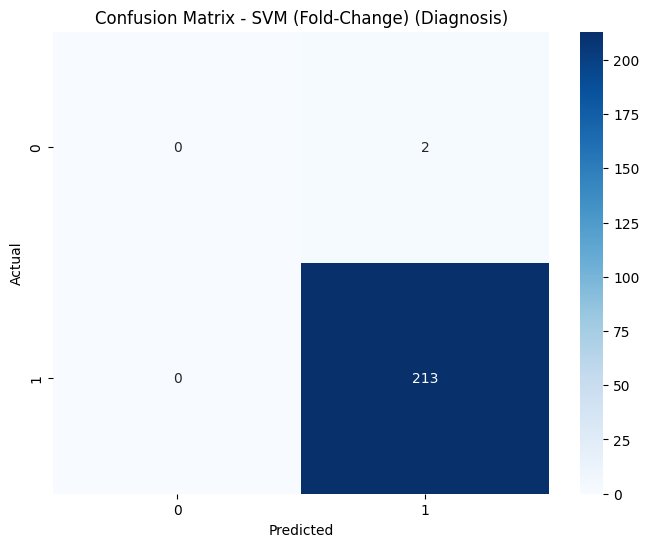


Diagnosis Correlation Matrix saved to ../results/svm_fold_change/svm_fold_change_diagnosis_correlation_matrix.png


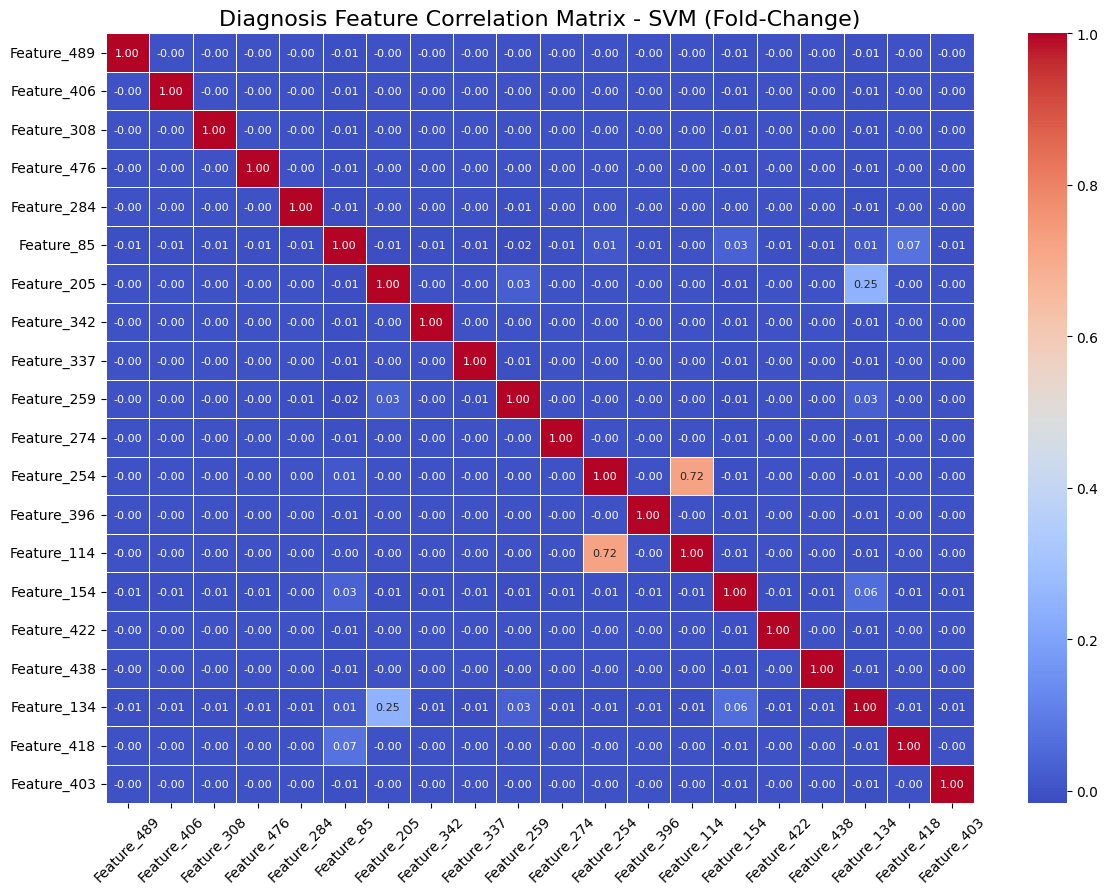


Diagnosis Covariance Matrix saved to ../results/svm_fold_change/svm_fold_change_diagnosis_covariance_matrix.png


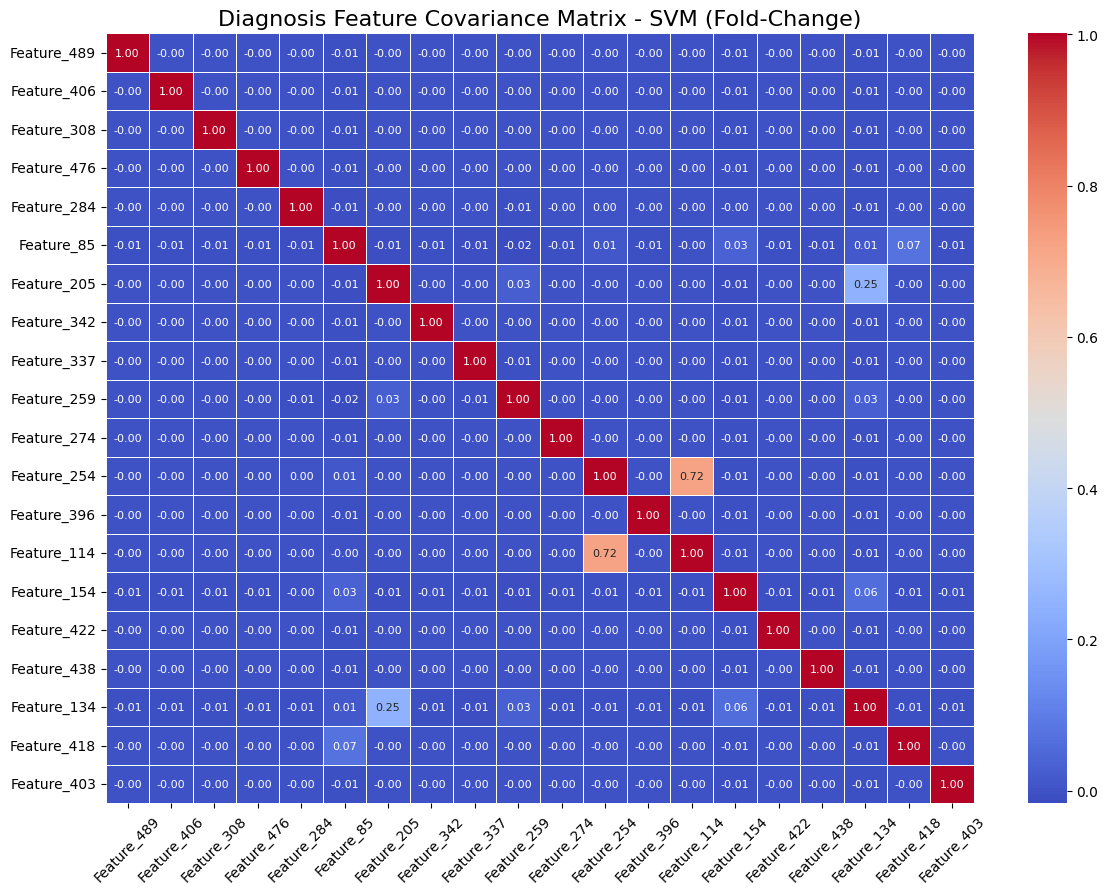


-------------------- SVM_Stage Results --------------------

Accuracy: 0.4093
Sensitivity (Recall): 0.1896
Specificity: 0.2292

Confusion Matrix:
 [[ 0  1  1  0  0]
 [ 0 71 24 16  1]
 [ 0 43 14  5  0]
 [ 0 23  8  3  0]
 [ 0  4  1  0  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.63      0.56       112
           2       0.29      0.23      0.25        62
           3       0.12      0.09      0.10        34
           4       0.00      0.00      0.00         5

    accuracy                           0.41       215
   macro avg       0.18      0.19      0.18       215
weighted avg       0.36      0.41      0.38       215


Confusion matrix saved to ../results/svm_fold_change/svm_fold_change_stage_confusion_matrix.png


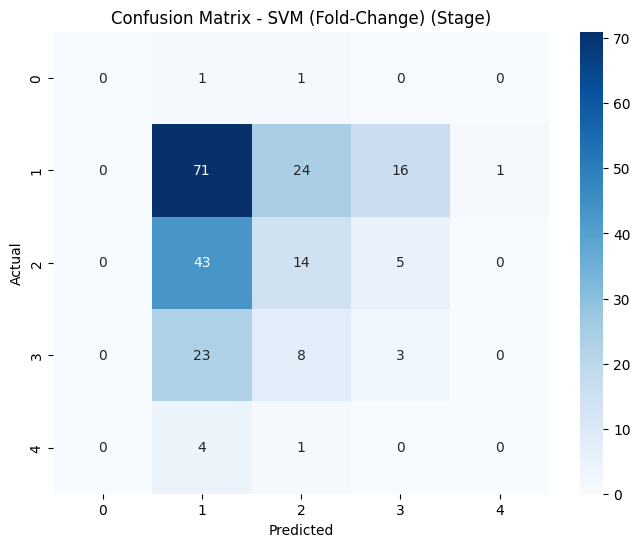


Stage Correlation Matrix saved to ../results/svm_fold_change/svm_fold_change_stage_correlation_matrix.png


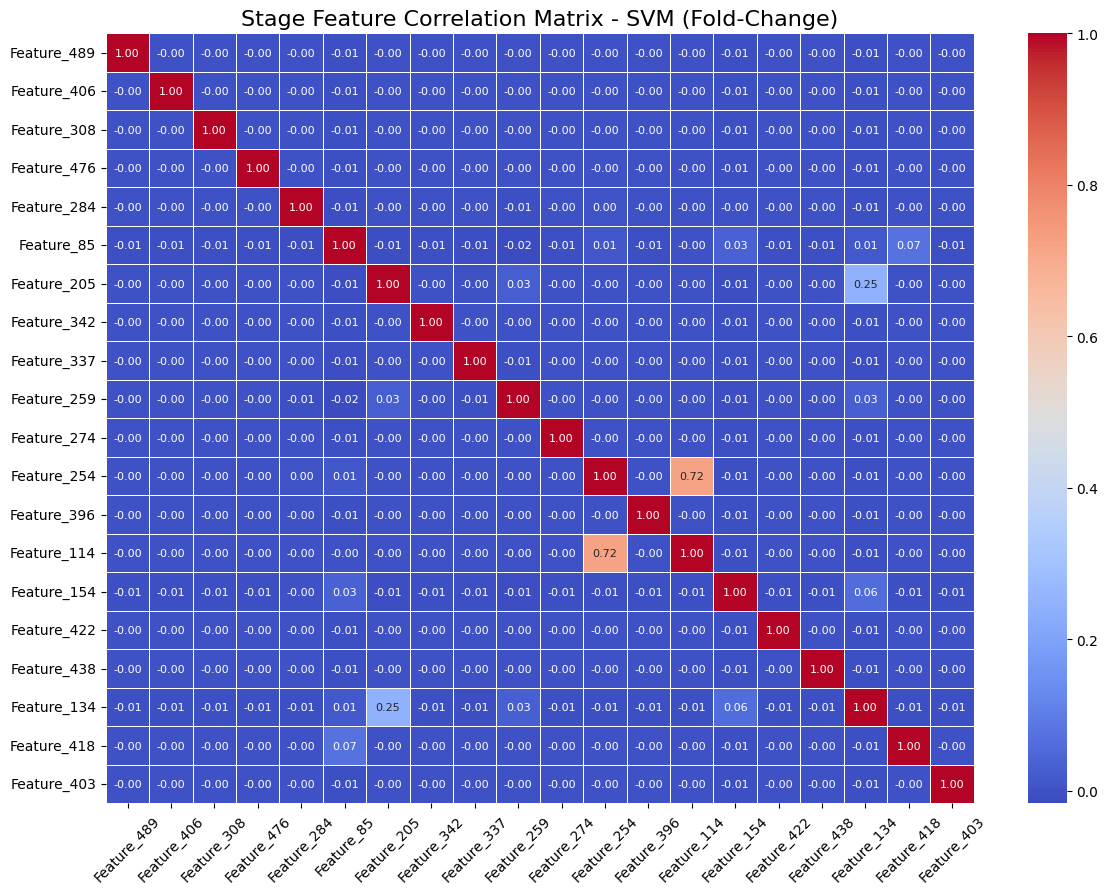


Stage Covariance Matrix saved to ../results/svm_fold_change/svm_fold_change_stage_covariance_matrix.png


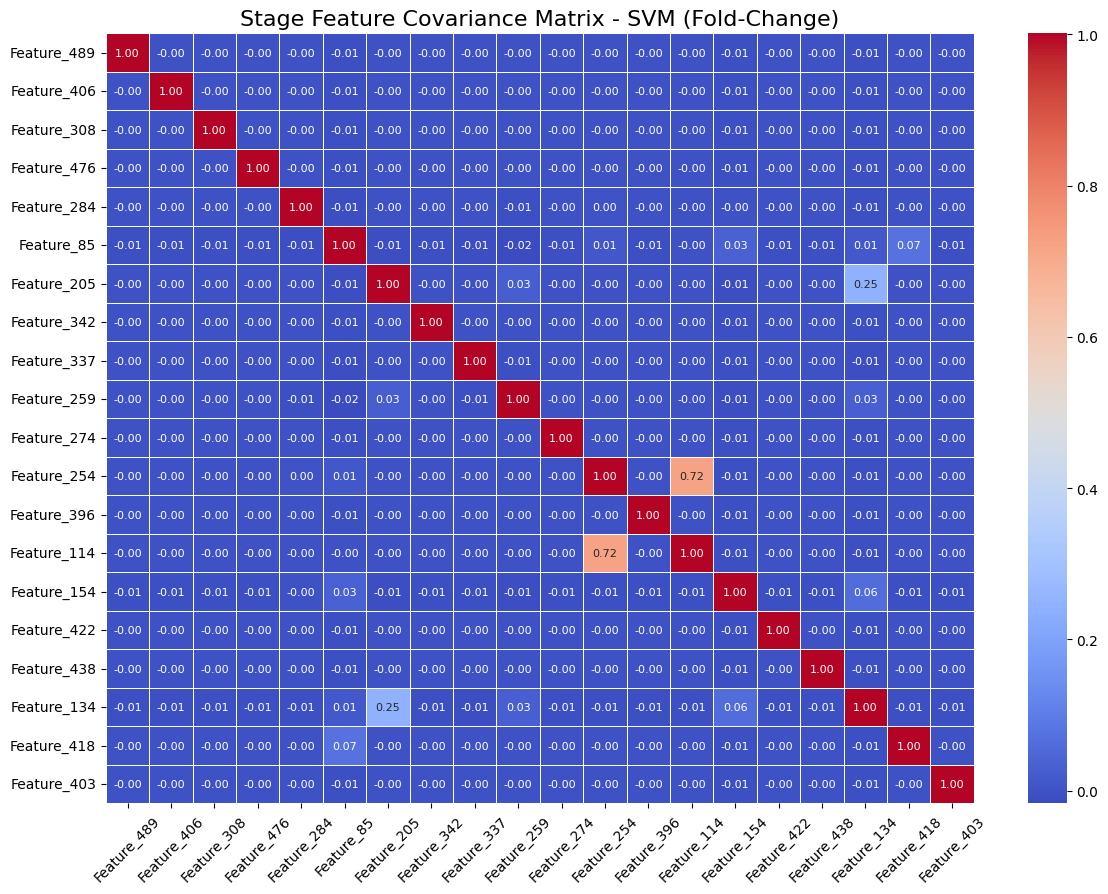


-------------------- SVM_Subtype Results --------------------

Accuracy: 0.5349
Sensitivity (Recall): 0.3604
Specificity: 0.5355

Confusion Matrix:
 [[ 0  1  1]
 [ 0 59 53]
 [ 0 45 56]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.56      0.53      0.54       112
           2       0.51      0.55      0.53       101

    accuracy                           0.53       215
   macro avg       0.36      0.36      0.36       215
weighted avg       0.53      0.53      0.53       215


Confusion matrix saved to ../results/svm_fold_change/svm_fold_change_subtype_confusion_matrix.png


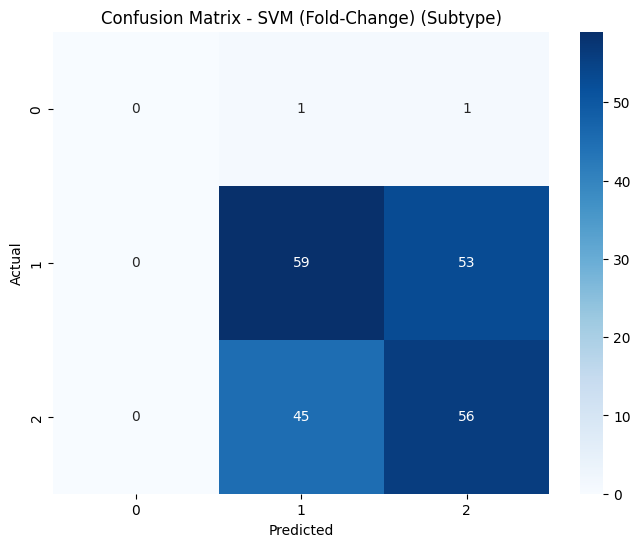


Subtype Correlation Matrix saved to ../results/svm_fold_change/svm_fold_change_subtype_correlation_matrix.png


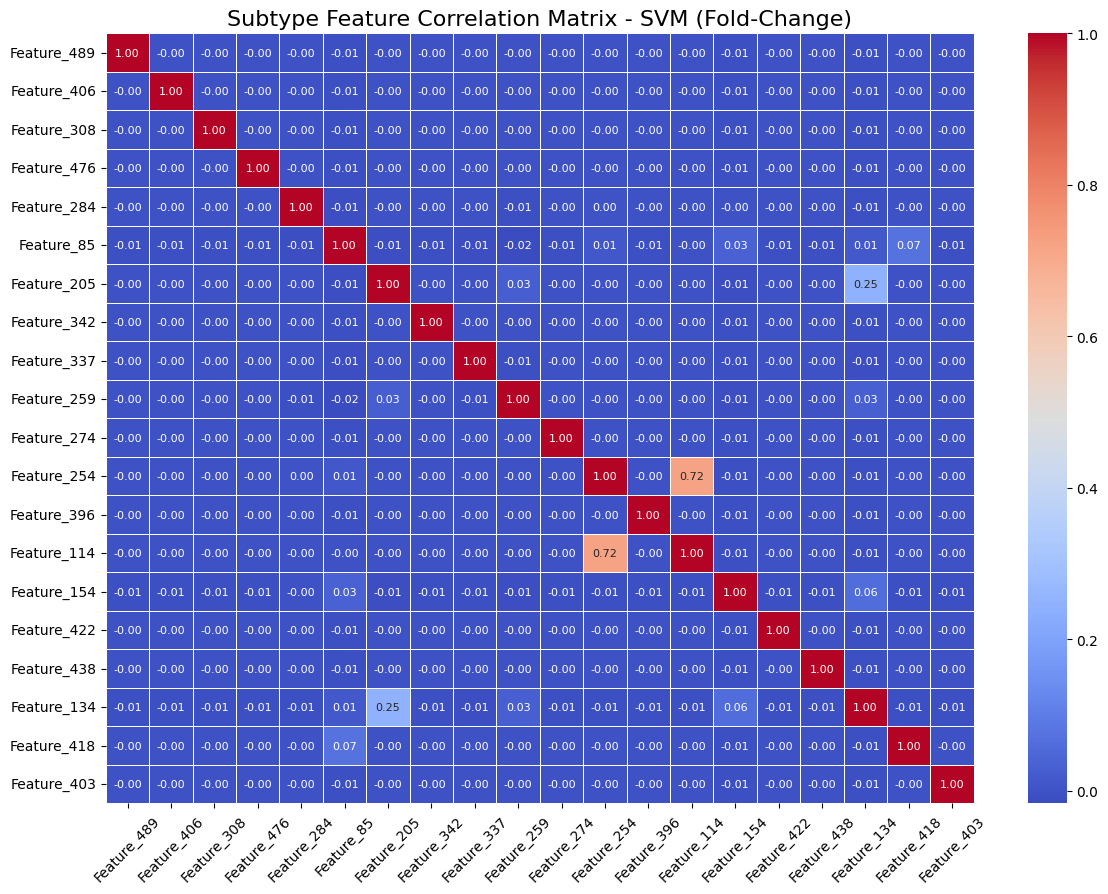


Subtype Covariance Matrix saved to ../results/svm_fold_change/svm_fold_change_subtype_covariance_matrix.png


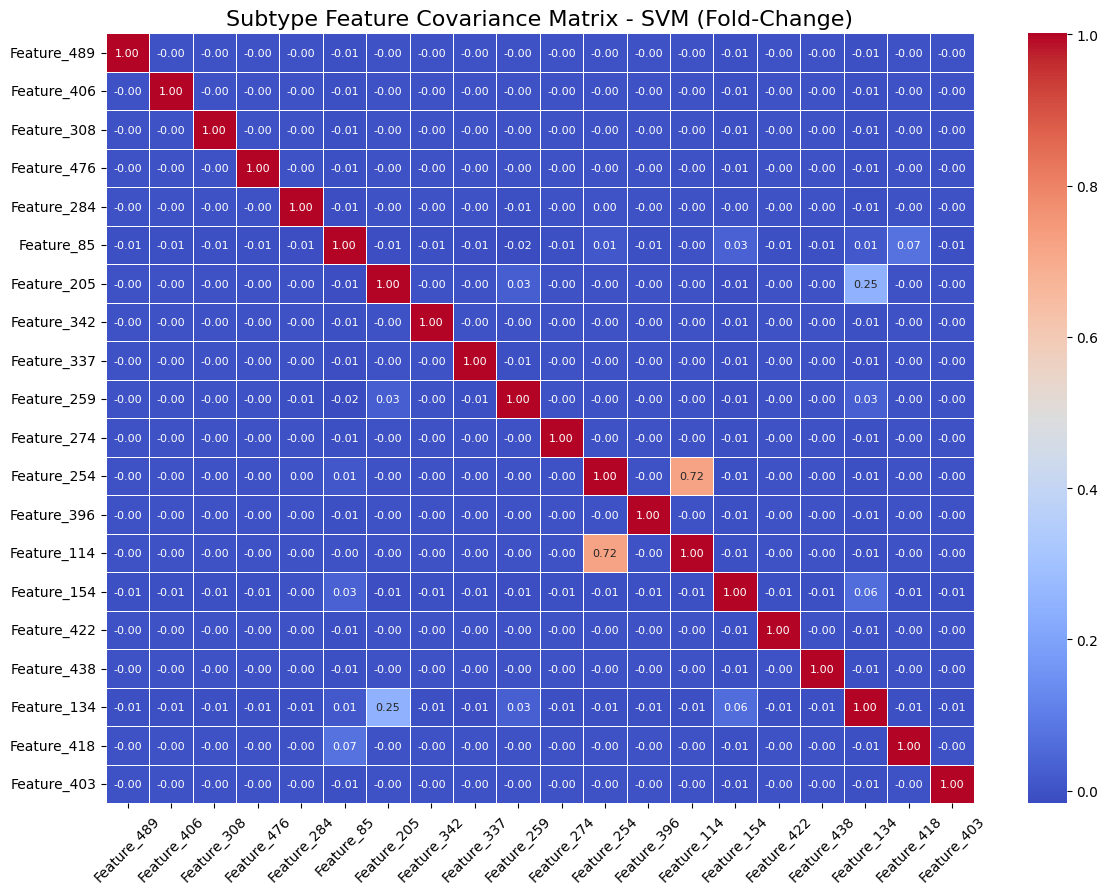

In [24]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import logging

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_multioutput_model(y_test, y_pred_diagnosis, y_pred_stage, y_pred_subtype, X_train, model_name="SVM (Fold-Change)", save_dir="../results/svm_fold_change/"):
    """
    Evaluate multi-output model performance for Diagnosis, Stage, and Subtype,
    including classification reports, confusion matrices, correlation, and covariance analysis.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Ensure y_test and predictions have the same shape
    min_length = min(len(y_test), len(y_pred_diagnosis), len(y_pred_stage), len(y_pred_subtype))
    y_test_aligned = y_test.iloc[:min_length].reset_index(drop=True)
    y_pred_diagnosis = y_pred_diagnosis[:min_length]
    y_pred_stage = y_pred_stage[:min_length]
    y_pred_subtype = y_pred_subtype[:min_length]

    # Convert predictions to DataFrame
    y_pred_df = pd.DataFrame({
        "diagnosis": y_pred_diagnosis,
        "stage": y_pred_stage,
        "subtype": y_pred_subtype
    })

    # Ensure X_train is a DataFrame
    if not isinstance(X_train, pd.DataFrame):
        print("\n⚠️ X_train was not a DataFrame, converting it now...")
        X_train = pd.DataFrame(X_train, columns=[f"Feature_{i}" for i in range(X_train.shape[1])])  # Assign column names

    # Define Function for Sensitivity & Specificity Calculation
    def calculate_metrics(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):  # Binary classification
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 1.0  # Avoid NaN
        else:  # Multi-class classification
            recall_values = np.diag(cm) / np.sum(cm, axis=1)
            precision_values = np.diag(cm) / np.sum(cm, axis=0)

            sensitivity = np.nanmean(recall_values)  # Macro-average recall
            specificity = np.nanmean(precision_values)  # Macro-average specificity

        return sensitivity, specificity

    # Evaluate Diagnosis
    diagnosis_accuracy = accuracy_score(y_test_aligned["diagnosis"], y_pred_df["diagnosis"])
    diagnosis_cm = confusion_matrix(y_test_aligned["diagnosis"], y_pred_df["diagnosis"])
    diagnosis_report = classification_report(y_test_aligned["diagnosis"], y_pred_df["diagnosis"], zero_division=0)
    diagnosis_sensitivity, diagnosis_specificity = calculate_metrics(y_test_aligned["diagnosis"], y_pred_df["diagnosis"])

    # Evaluate Stage
    stage_accuracy = accuracy_score(y_test_aligned["stage"], y_pred_df["stage"])
    stage_cm = confusion_matrix(y_test_aligned["stage"], y_pred_df["stage"])
    stage_report = classification_report(y_test_aligned["stage"], y_pred_df["stage"], zero_division=0)
    stage_sensitivity, stage_specificity = calculate_metrics(y_test_aligned["stage"], y_pred_df["stage"])

    # Evaluate Subtype
    subtype_accuracy = accuracy_score(y_test_aligned["subtype"], y_pred_df["subtype"])
    subtype_cm = confusion_matrix(y_test_aligned["subtype"], y_pred_df["subtype"])
    subtype_report = classification_report(y_test_aligned["subtype"], y_pred_df["subtype"], zero_division=0)
    subtype_sensitivity, subtype_specificity = calculate_metrics(y_test_aligned["subtype"], y_pred_df["subtype"])

    # Identify and Save Top 10 Features
    top_10_features = X_train.var().sort_values(ascending=False).index[:10].tolist()
    print("\nTop 10 Features Based on Maximum Variance:")
    print(top_10_features)

    top_features_path = os.path.join(save_dir, f"svm_fold_change_top_features.txt")
    with open(top_features_path, "w") as f:
        for feature in top_10_features:
            f.write(feature + "\n")
    print(f"\nTop features saved to {top_features_path}")

    print(f"\n{'-'*20} {model_name} Results {'-'*20}")

    # Display and Save Confusion, Correlation, and Covariance Matrices
    for label, cm, name, acc, sens, spec, report in [
        ("diagnosis", diagnosis_cm, "Diagnosis", diagnosis_accuracy, diagnosis_sensitivity, diagnosis_specificity, diagnosis_report),
        ("stage", stage_cm, "Stage", stage_accuracy, stage_sensitivity, stage_specificity, stage_report),
        ("subtype", subtype_cm, "Subtype", subtype_accuracy, subtype_sensitivity, subtype_specificity, subtype_report)
    ]:
        print(f"\n-------------------- SVM_{name} Results --------------------\n")
        print(f"Accuracy: {acc:.4f}")
        print(f"Sensitivity (Recall): {sens:.4f}")
        print(f"Specificity: {spec:.4f}\n")
        print("Confusion Matrix:\n", cm)
        print("\nClassification Report:\n", report)

        # Save Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {model_name} ({name})")

        cm_path = os.path.join(save_dir, f"svm_fold_change_{label}_confusion_matrix.png")
        plt.savefig(cm_path)
        print(f"\nConfusion matrix saved to {cm_path}")
        plt.show()

        # Save Correlation and Covariance Matrices
        top_variance_features = X_train.var().sort_values(ascending=False).index[:20]
        filtered_corr_matrix = X_train[top_variance_features].corr()
        filtered_cov_matrix = X_train[top_variance_features].cov()

        for matrix, matrix_name in [(filtered_corr_matrix, "correlation"), (filtered_cov_matrix, "covariance")]:
            plt.figure(figsize=(14, 10))
            sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
            plt.title(f"{name} Feature {matrix_name.capitalize()} Matrix - {model_name}", fontsize=16)
            plt.xticks(fontsize=10, rotation=45)
            plt.yticks(fontsize=10)

            matrix_path = os.path.join(save_dir, f"svm_fold_change_{label}_{matrix_name}_matrix.png")
            plt.savefig(matrix_path)
            print(f"\n{name} {matrix_name.capitalize()} Matrix saved to {matrix_path}")
            plt.show()

    return {
        "diagnosis_accuracy": diagnosis_accuracy,
        "stage_accuracy": stage_accuracy,
        "subtype_accuracy": subtype_accuracy,
        "diagnosis_sensitivity": diagnosis_sensitivity,
        "stage_sensitivity": stage_sensitivity,
        "subtype_sensitivity": subtype_sensitivity,
        "diagnosis_specificity": diagnosis_specificity,
        "stage_specificity": stage_specificity,
        "subtype_specificity": subtype_specificity,
        "top_10_features": top_10_features
    }

# Run Evaluation for Fold-Change Feature Selection
save_dir = "../results/svm_fold_change/"
metrics_fold_change = evaluate_multioutput_model(y_test, y_pred_diagnosis, y_pred_stage, y_pred_subtype, X_train, model_name="SVM (Fold-Change)", save_dir=save_dir)


### Save Everything & Finalize the Pipeline (Fold-Change Only)

In [25]:
import os
import json
import logging

# Define Output Directory
output_dir = "../results/svm_fold_change/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Ensure `metrics` contains the necessary keys before accessing them
metadata = {
    "diagnosis_hyperparameters": grid_diagnosis.best_params_ if "grid_diagnosis" in locals() else "N/A",
    "stage_hyperparameters": grid_stage.best_params_ if "grid_stage" in locals() else "N/A",
    "subtype_hyperparameters": grid_subtype.best_params_ if "grid_subtype" in locals() else "N/A",
    "diagnosis_accuracy": metrics.get("diagnosis", {}).get("accuracy", "N/A"),
    "stage_accuracy": metrics.get("stage", {}).get("accuracy", "N/A"),
    "subtype_accuracy": metrics.get("subtype", {}).get("accuracy", "N/A"),
    "diagnosis_sensitivity": metrics.get("diagnosis", {}).get("sensitivity", "N/A"),
    "stage_sensitivity": metrics.get("stage", {}).get("sensitivity", "N/A"),
    "subtype_sensitivity": metrics.get("subtype", {}).get("sensitivity", "N/A"),
    "diagnosis_specificity": metrics.get("diagnosis", {}).get("specificity", "N/A"),
    "stage_specificity": metrics.get("stage", {}).get("specificity", "N/A"),
    "subtype_specificity": metrics.get("subtype", {}).get("specificity", "N/A"),
    "diagnosis_confusion_matrix": metrics.get("diagnosis", {}).get("confusion_matrix", "N/A"),
    "stage_confusion_matrix": metrics.get("stage", {}).get("confusion_matrix", "N/A"),
    "subtype_confusion_matrix": metrics.get("subtype", {}).get("confusion_matrix", "N/A"),
    "train_set_size": X_train.shape[0] if "X_train" in locals() else "N/A",
    "test_set_size": X_test.shape[0] if "X_test" in locals() else "N/A"
}

# Print Debug Info Before Saving
print("\n🔍 DEBUG: Final Metadata Before Saving:")
print(json.dumps(metadata, indent=4))

# Save Metadata to JSON
metadata_path = os.path.join(output_dir, "svm_fold_change_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

logging.info(f"Metadata successfully saved to {metadata_path}")
print(f"Metadata successfully saved to {metadata_path}")

2025-02-26 21:03:58,724 - INFO - Metadata successfully saved to ../results/svm_fold_change/svm_fold_change_metadata.json



🔍 DEBUG: Final Metadata Before Saving:
{
    "diagnosis_hyperparameters": {
        "C": 0.1,
        "gamma": 1,
        "kernel": "rbf"
    },
    "stage_hyperparameters": {
        "C": 10,
        "gamma": "scale",
        "kernel": "rbf"
    },
    "subtype_hyperparameters": {
        "C": 10,
        "gamma": "scale",
        "kernel": "rbf"
    },
    "diagnosis_accuracy": 0.9907834101382489,
    "stage_accuracy": 0.786046511627907,
    "subtype_accuracy": 0.9488372093023256,
    "diagnosis_sensitivity": 1.0,
    "stage_sensitivity": 0.5385475714693527,
    "subtype_sensitivity": 0.9501126907073509,
    "diagnosis_specificity": 0.0,
    "stage_specificity": 0.5964642018779343,
    "subtype_specificity": 0.9495670995670995,
    "diagnosis_confusion_matrix": "N/A",
    "stage_confusion_matrix": "N/A",
    "subtype_confusion_matrix": "N/A",
    "train_set_size": 866,
    "test_set_size": 217
}
Metadata successfully saved to ../results/svm_fold_change/svm_fold_change_metadata.json
